In [118]:
import geopandas as gp
import pandas as pd
import os

from collections import Counter

# 2022 Montana General Election Precinct Boundaries and Election Results

## Load Files

In [119]:
mt_precincts = gp.read_file("./raw-from-source/MontanaVotingPrecincts_shp/VotingPrecincts.shp")
mt_results = pd.read_csv("./raw-from-source/mt_2022_gen_prec/mt_2022_gen_prec.csv")

In [120]:
races = [i for i in mt_results.columns if i not in ['UNIQUE_ID', 'COUNTYFP', 'COUNTYNM', 'PRECINCT']]

## Basic File Cleaning

In [121]:
mt_precincts.loc[mt_precincts["COUNTYFP20"].isna(),"COUNTYFP20"] = "29"
mt_precincts["UNIQUE_ID"] = mt_precincts["COUNTYFP20"].astype(int).astype(str)+"-:-"+mt_precincts["NUMBER"].astype(str)
ser = mt_precincts["UNIQUE_ID"].value_counts()
dups = list(ser[ser>1].index)

## Clean Duplicated and Unjoined Precincts


In [122]:
mt_precincts = mt_precincts.dissolve("UNIQUE_ID")
mt_precincts.reset_index(inplace = True, drop = False)

## Modify Precinct Names for Join

Note: The file below was created by hand

In [123]:
correspondence_table = pd.read_csv("./raw-from-source/Supporting_Files/correspondence_table.csv")
correspondence_table = correspondence_table[correspondence_table["UNIQUE_ID"]!=correspondence_table["SHP_ID"]]
correspondence_table_dict = dict(zip(correspondence_table["UNIQUE_ID"], correspondence_table["SHP_ID"]))

mt_results["UNIQUE_ID"] = mt_results["UNIQUE_ID"].map(correspondence_table_dict).fillna(mt_results["UNIQUE_ID"])

correspondence_table = pd.read_csv("./raw-from-source/Supporting_Files/correspondence_table.csv")
correspondence_table = correspondence_table[correspondence_table["UNIQUE_ID"]!=correspondence_table["SHP_ID"]]
correspondence_table_dict = dict(zip(correspondence_table["UNIQUE_ID"], correspondence_table["SHP_ID"]))

mt_results["UNIQUE_ID"] = mt_results["UNIQUE_ID"].map(correspondence_table_dict).fillna(mt_results["UNIQUE_ID"]) 

In [124]:
mt_precincts = mt_precincts[["UNIQUE_ID", "geometry", "HOUSE", "SENATE","POLLINGPLA","PrecinctNa"]]

In [125]:
joined_pber = gp.GeoDataFrame(pd.merge(mt_results, mt_precincts, how = "outer", on = "UNIQUE_ID", indicator = True))

In [126]:
mt_fip_dict = dict(zip(mt_results["COUNTYFP"].astype(str).str.zfill(3), mt_results["COUNTYNM"]))

In [127]:
joined_pber["_merge"].value_counts()

both          663
right_only      2
left_only       0
Name: _merge, dtype: int64

## Clean the Precincts Only in Shapefile

In [128]:
joined_pber.loc[joined_pber["_merge"]!="both","COUNTYFP"] = joined_pber.loc[joined_pber["_merge"]!="both","UNIQUE_ID"].apply(lambda x: x.split("-:-")[0].zfill(3))
joined_pber.loc[joined_pber["_merge"]!="both","PRECINCT"] = "NA"
joined_pber.loc[joined_pber["_merge"]!="both","COUNTYNM"] = joined_pber.loc[joined_pber["_merge"]!="both","COUNTYFP"].map(mt_fip_dict)

joined_pber = joined_pber.fillna(0)

joined_pber.drop("_merge", axis = 1, inplace = True)

## Examine Split Precincts

In [129]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:5]
    elif column_name[0:4] == "GCON":
        level = "CON"
        dist = column_name[4]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]
        
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in joined_pber.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0) and ("GCON" in contest or "GSL" in contest or "GSU" in contest):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
cong_check_list = {i:contains_cong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldu_check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldl_check_list = {i:contains_sldl(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [130]:
def return_splits(split_dict, level):
    for val in split_dict.keys():
        if level in val:
            return split_dict[level]

def create_splits_dict(level):
    level_splits_dict = {i:return_splits(split_precincts_list[i], level) for i in split_precincts_list.keys() if return_splits(split_precincts_list[i], level) != None }
    return level_splits_dict

In [131]:
cong_splits_dict = create_splits_dict('CON')
sldl_splits_dict = create_splits_dict('SL')
sldu_splits_dict = create_splits_dict('SU')

In [132]:
print(cong_splits_dict)

{'73-:-000035': ['1', '2']}


In [133]:
print(sldl_splits_dict)

{'111-:-040-45': ['040', '045']}


In [134]:
print(sldu_splits_dict)

{}


In [135]:
def district_splits_comb(level, splits_list, elections_gdf, district_gdf, unique_ID_col, district_gdf_ID, races_list, elections_gdf_dist_ID, fill_level = 2):
    '''
    Function to split precincts across districts that splits a precinct across the entire district map.
    Previous iterations of this code only split precincts by the districts in which votes were recorded.
    In some instances, that led to holes in the map, due to districts where no votes were recorded in a precinct, but where an intersection occurred.
    '''
    # Intersect the elections gdf with the district gdf
    need_splits = elections_gdf[elections_gdf[unique_ID_col].isin(splits_list)]
    others = elections_gdf[~elections_gdf[unique_ID_col].isin(splits_list)]
    
    pre_splits_copy = need_splits.copy(deep = True)
    
    test_join = gp.overlay(need_splits, district_gdf, how = "intersection")
    
    # Assign a district column, using the district shapefile
    test_join[elections_gdf_dist_ID] = test_join[district_gdf_ID]
    
    # Filter the intersection down to the precinct, district pairs we need
    clean_votes = test_join.copy(deep = True)
    
    clean_votes[unique_ID_col+"_new"] = clean_votes[unique_ID_col]
    
    # Remove the others and hold on to these to be merged later
    for index, row in clean_votes.iterrows():
        clean_votes.at[index, unique_ID_col+"_new"] = row[unique_ID_col]+"-("+level + "-" + row[district_gdf_ID].zfill(fill_level) + ")"
        for column in test_join:
            if column in races_list and row[elections_gdf_dist_ID].zfill(fill_level) not in column:
                clean_votes.at[index, column] = 0 
        
    lost_votes_df = generate_differences_df(pre_splits_copy, clean_votes, unique_ID_col, races_list, True)
    
    clean_votes.drop(unique_ID_col, axis = 1, inplace = True)
    clean_votes.rename(columns = {unique_ID_col+"_new":unique_ID_col}, inplace = True)

    clean_votes = clean_votes[list(others.columns)]
        
    elections_gdf = gp.GeoDataFrame(pd.concat([clean_votes, others]), crs = elections_gdf.crs)
    elections_gdf.reset_index(drop=True,inplace=True)

    
    return elections_gdf, lost_votes_df

In [136]:
def generate_differences_df(df_compare_against, df_compare_to, unique_ID_col, races_list, drop_empty = False):
    
    df_compare_against = df_compare_against[[unique_ID_col]+races_list]
    df_compare_to = df_compare_to[[unique_ID_col]+races_list]
 

    grouped_compare_against = df_compare_against.groupby(unique_ID_col).sum()
    grouped_compare_to = df_compare_to.groupby(unique_ID_col).sum()
    
    grouped_compare_against.reset_index(inplace = True, drop = False)
    grouped_compare_to.reset_index(inplace = True, drop = False)

    diffs = grouped_compare_against.set_index(unique_ID_col).subtract(grouped_compare_to.set_index(unique_ID_col))
    
    diffs["Tot_Votes"] = diffs[races_list].sum(axis=1)

    
    if drop_empty:
        diffs = diffs.loc[~(diffs==0).all(axis=1)]
        diffs = diffs.loc[:, (diffs != 0).any(axis=0)]

    return diffs

In [ ]:
SLDU_PATH = ""
SLDL_PATH = ""
CONG_PATH = ""

In [137]:


# Load in post-redistricting SLDU and SLDL shapefiles
mt_sldu_districts = gp.read_file(SLDU_PATH)
mt_sldl_districts = gp.read_file(SLDL_PATH)
mt_cong_districts = gp.read_file(CONG_PATH)

mt_sldu_districts = mt_sldu_districts.to_crs(joined_pber.crs)
mt_sldl_districts = mt_sldl_districts.to_crs(joined_pber.crs)
mt_cong_districts = mt_cong_districts.to_crs(joined_pber.crs)

mt_sldu_districts = mt_sldu_districts[mt_sldu_districts["STATE"]=="MT"]
mt_sldl_districts = mt_sldl_districts[mt_sldl_districts["STATE"]=="MT"]
mt_cong_districts = mt_cong_districts[mt_cong_districts["STATE"]=="MT"]

## Split File into 3 To Account for CONG and SLDL Splits

In [138]:
# Make SLDU and SLDL district assignments using the above
joined_pber["SLDU_DIST"] = joined_pber["UNIQUE_ID"].map(sldu_check_list)
joined_pber["SLDL_DIST"] = joined_pber["UNIQUE_ID"].map(sldl_check_list)
joined_pber["CONG_DIST"] = joined_pber["UNIQUE_ID"].map(cong_check_list)

In [139]:
keep_names = ['UNIQUE_ID','COUNTYFP','COUNTYNM','PRECINCT', 'geometry','HOUSE','SENATE','POLLINGPLA','PrecinctNa']
sldl_columns = [i for i in joined_pber.columns if i not in keep_names and "GSL" in i and i not in ["SLDU_DIST","SLDL_DIST","CONG_DIST"]]
cong_columns = [i for i in joined_pber.columns if i not in keep_names and "GCON" in i and i not in ["SLDU_DIST","SLDL_DIST","CONG_DIST"]]
other_columns = [i for i in joined_pber.columns if i not in keep_names and "GSL" not in i and i not in ["SLDU_DIST","SLDL_DIST","CONG_DIST"]]


mt_22_st_sldu_prec = joined_pber[keep_names + ["SLDU_DIST"] + other_columns].copy(deep = True)
mt_22_sldl_prec = joined_pber[keep_names + ["SLDL_DIST"] + sldl_columns].copy(deep = True)
mt_22_cong_prec = joined_pber[keep_names + ["CONG_DIST"] + cong_columns].copy(deep = True)

In [140]:
mt_cong_districts["DISTRICT"] = mt_cong_districts["DISTRICT"].astype(int).astype(str)

mt_22_sldl_prec, sldl_diff = district_splits_comb("SL", list(sldl_splits_dict.keys()), mt_22_sldl_prec, mt_sldl_districts, "UNIQUE_ID", "DISTRICT", sldl_columns, "SLDL_DIST", fill_level = 3)
mt_22_cong_prec, cong_diff = district_splits_comb("CON", list(cong_splits_dict.keys()), mt_22_cong_prec, mt_cong_districts, "UNIQUE_ID", "DISTRICT", cong_columns, "CONG_DIST", fill_level = 1)

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [141]:
# The precinct shapefiles already contained district assignment fields, look into instances
# where that file does not match the assignment we provided based off election results
print(joined_pber[joined_pber["SLDU_DIST"]!=joined_pber["SENATE"]].shape)

print(joined_pber[joined_pber["SLDL_DIST"]!=joined_pber["HOUSE"]].shape)

(389, 257)
(661, 257)


## Clean up Unassigned Districts

In [142]:
def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID, ):
    
    if elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()].shape[0]==0:
        print("No assignments to make")
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()], district_gdf, how = "intersection")

    dist_clean['area'] = dist_clean.area

    na_assignment_dict = {}

    for val in dist_clean[unique_ID_col].unique():

        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment

    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    

    elections_gdf = elections_gdf.to_crs(original_crs)
    
    return elections_gdf

In [143]:
mt_22_sldl_prec = clean_na_dist_assignments(mt_22_sldl_prec, mt_sldl_districts, "UNIQUE_ID", "SLDL_DIST", "DISTRICT")
mt_22_st_sldu_prec = clean_na_dist_assignments(mt_22_st_sldu_prec, mt_sldu_districts, "UNIQUE_ID", "SLDU_DIST", "DISTRICT")
mt_22_cong_prec = clean_na_dist_assignments(mt_22_cong_prec, mt_cong_districts, "UNIQUE_ID", "CONG_DIST", "DISTRICT")


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [144]:
mt_22_st_sldu_prec["SLDU_DIST"] = mt_22_st_sldu_prec["SLDU_DIST"].astype(str).str.zfill(2)
mt_22_st_sldu_prec["SENATE"] = mt_22_st_sldu_prec["SENATE"].astype(str).str.zfill(2)

In [145]:
mt_22_sldl_prec["SLDL_DIST"] = mt_22_sldl_prec["SLDL_DIST"].astype(str).str.zfill(3)
mt_22_sldl_prec["HOUSE"] = mt_22_sldl_prec["HOUSE"].astype(str).str.zfill(3)

## Look Into Precincts Where Election Assignment Doesn't Match Shapefile Assignment from File

In [146]:
mt_22_sldl_prec[mt_22_sldl_prec["SLDL_DIST"]!=mt_22_sldl_prec["HOUSE"]][["SLDL_DIST","HOUSE"]]

,SLDL_DIST,HOUSE
1,046,040
2,043,040
3,045,040
666,015,010


In [147]:
mt_22_st_sldu_prec[mt_22_st_sldu_prec["SLDU_DIST"]!=mt_22_st_sldu_prec["SENATE"]][["SLDU_DIST","SENATE"]]

,SLDU_DIST,SENATE
572,39,36
663,08,05


## Check Geometries

In [154]:
from matplotlib.lines import Line2D
import contextily as cx

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,shape_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" "+shape_name +" for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10), alpha = .5)
                right_geoms.iloc[[index]].plot(color="blue",ax=base, alpha = .5)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                cx.add_basemap(ax = base, crs = gdf_1.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10), alpha = .5)
                right_geoms.iloc[[index]].plot(color="blue",ax=base, alpha = .5)
                intersection.plot(color="green",ax=base, alpha = .8)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                cx.add_basemap(ax = base, crs = gdf_1.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" "+ shape_name+ ":")
    print()
    print(str(len(df[df[0]==0]))+" "+shape_name+"  w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " "+shape_name+"  w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " "+shape_name+"  w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " "+shape_name+"  w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " "+shape_name+"  w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " "+shape_name+"  w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " "+shape_name+"  w/ a difference greater than 5 km^2")

Checking 50 districts for differences of greater than 2 km^2

1) For 05 difference in area is 68.15565111178041
2) For 08 difference in area is 69.26585468905192
3) For 14 difference in area is 2.737583835428615
4) For 16 difference in area is 4.254487802972708
5) For 17 difference in area is 2.403238426878914
6) For 19 difference in area is 2.424832373953586
7) For 20 difference in area is 7.463573147413479
8) For 23 difference in area is 5.305980776064103

Scroll down to see plots of any differences

Of the 50 districts:

0 districts  w/ a difference of 0 km^2
16 districts  w/ a difference between 0 and .1 km^2
20 districts  w/ a difference between .1 and .5 km^2
3 districts  w/ a difference between .5 and 1 km^2
3 districts  w/ a difference between 1 and 2 km^2
4 districts  w/ a difference between 2 and 5 km^2
4 districts  w/ a difference greater than 5 km^2
Checking 100 districts for differences of greater than 2 km^2

1) For 010 difference in area is 68.14358576408397
2) For 015 d

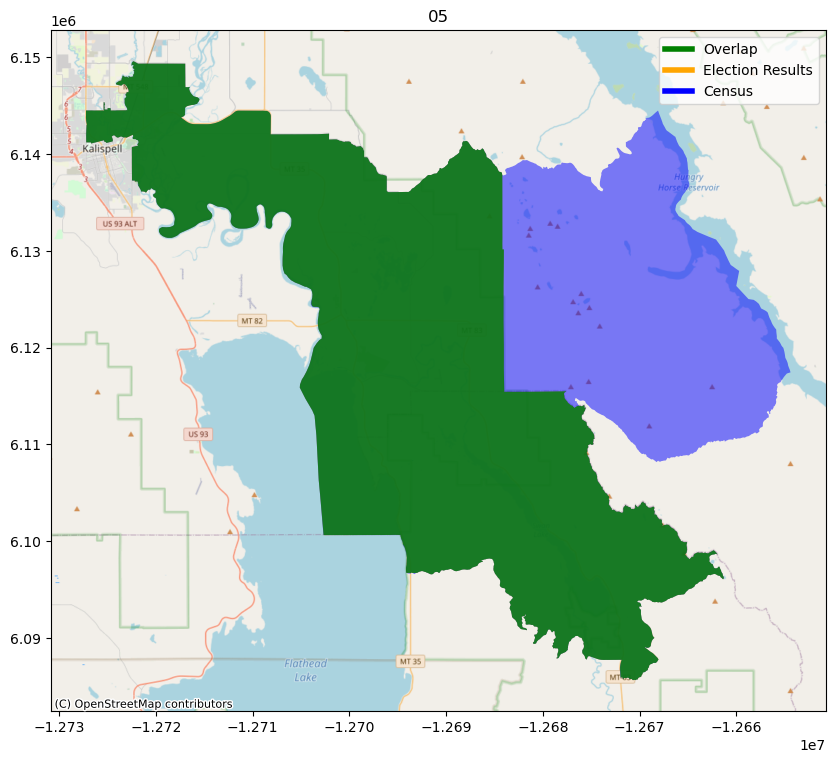

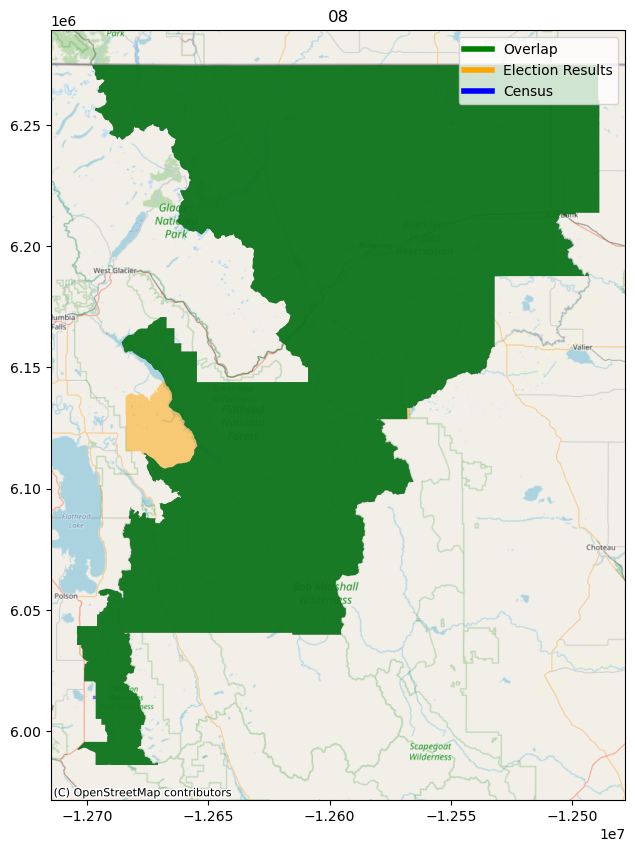

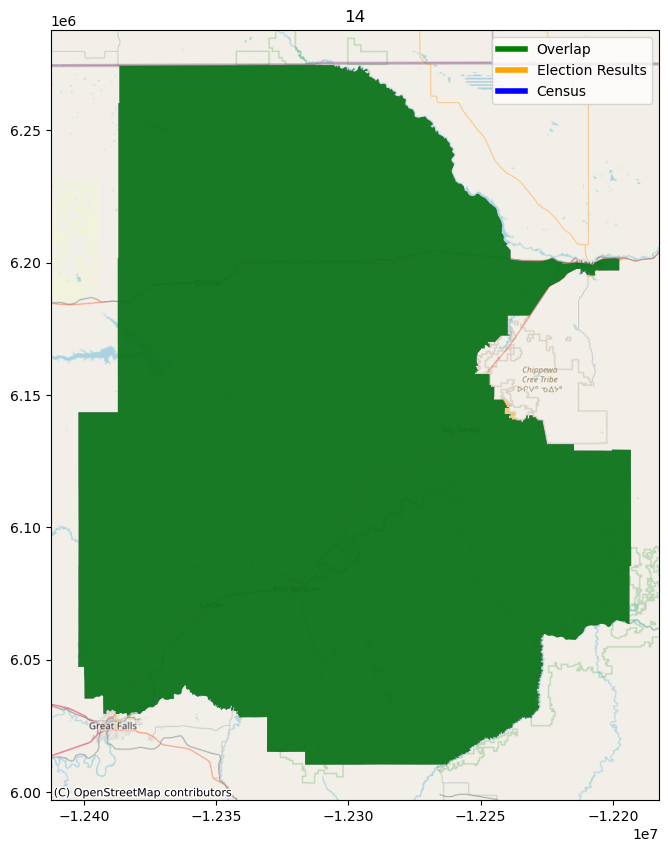

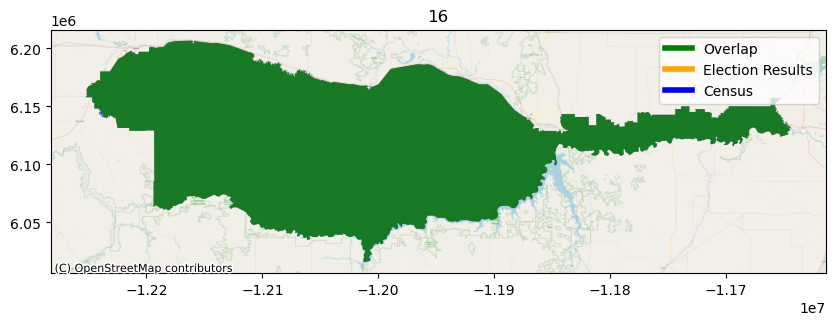

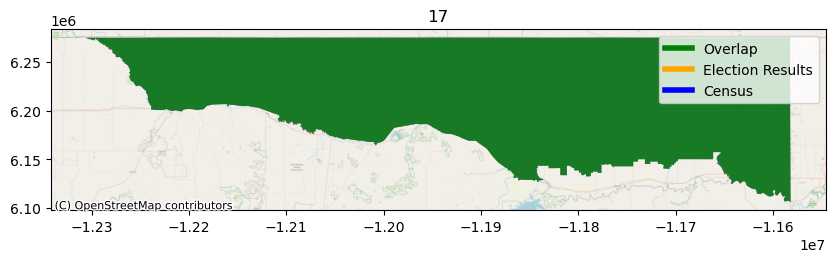

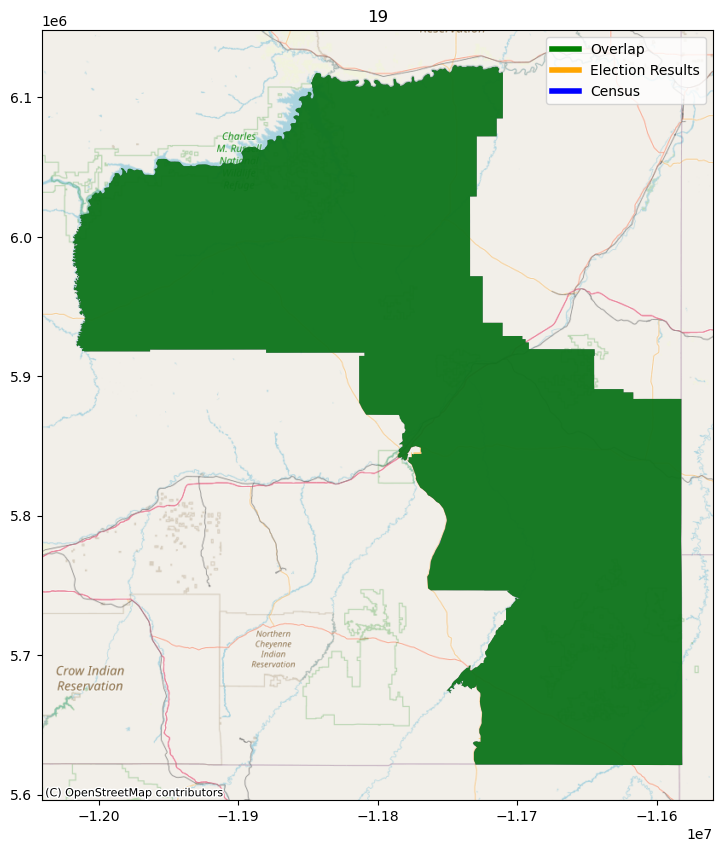

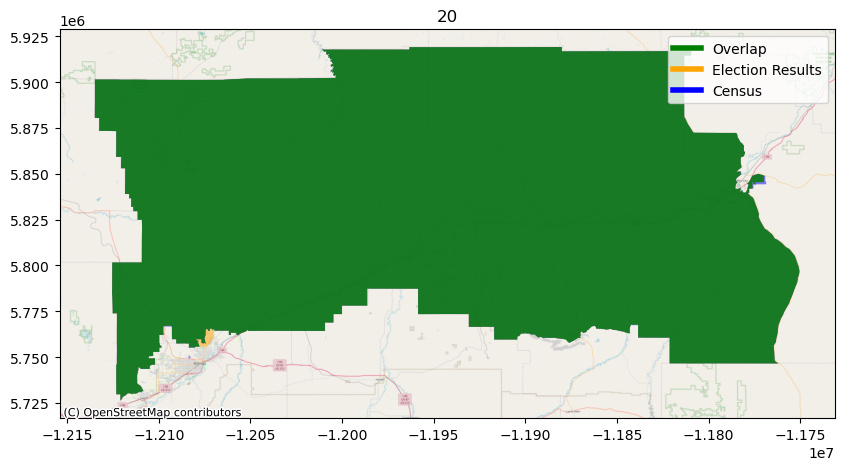

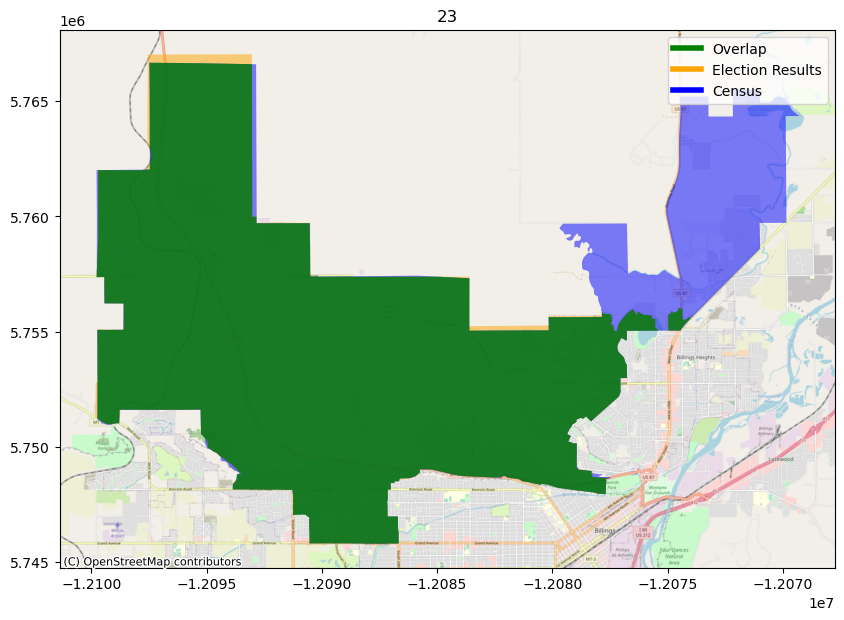

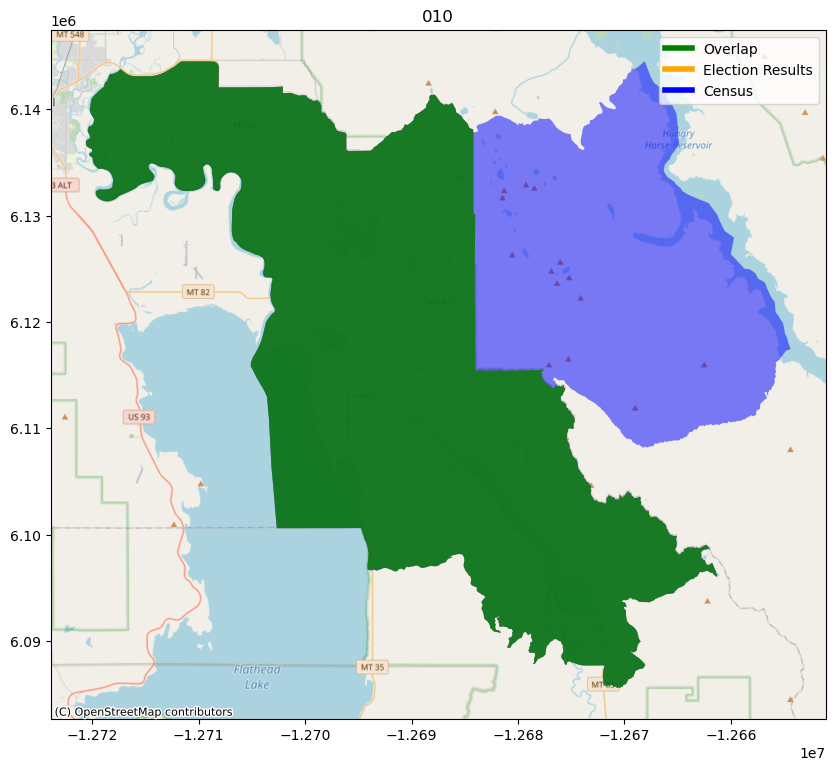

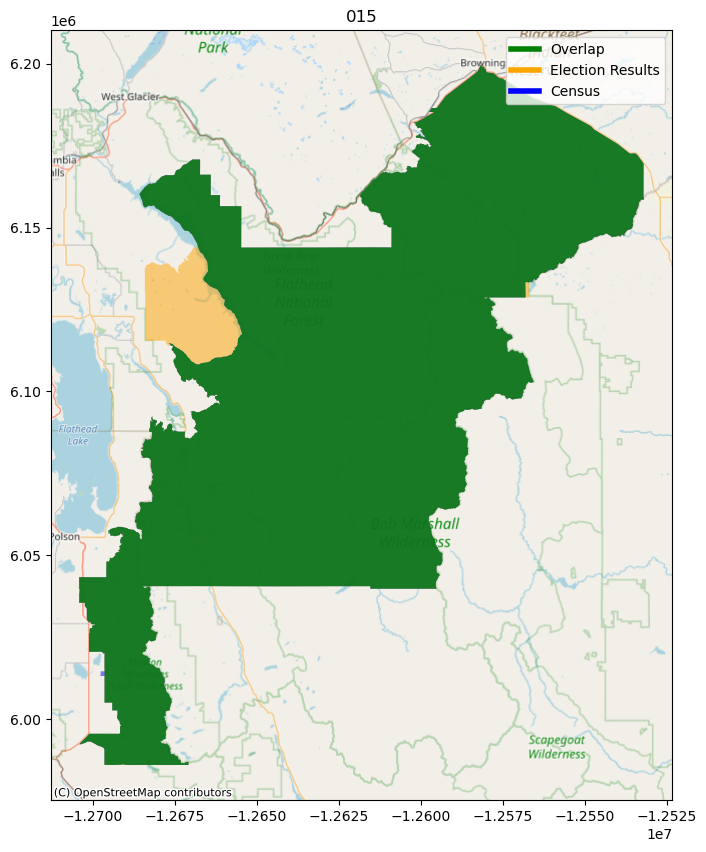

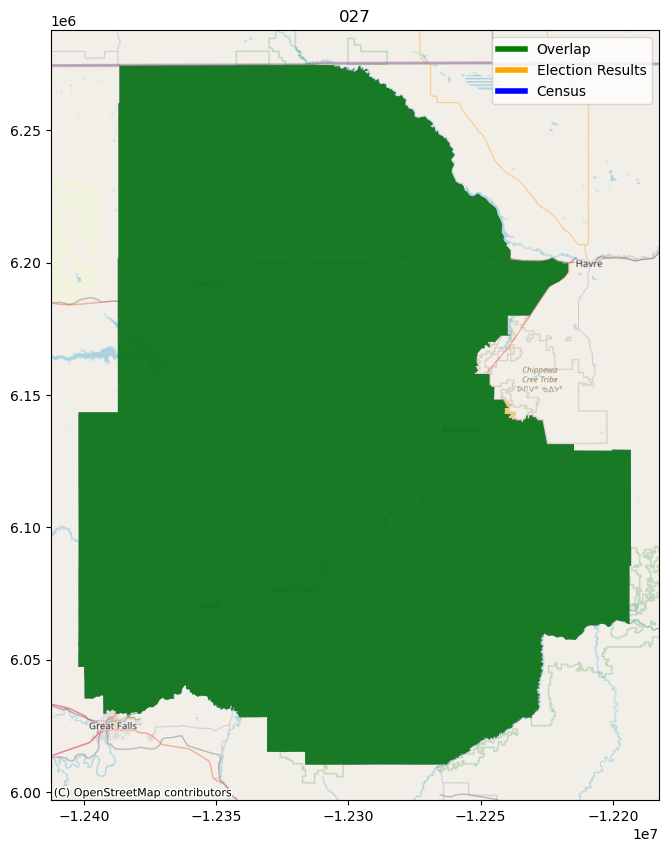

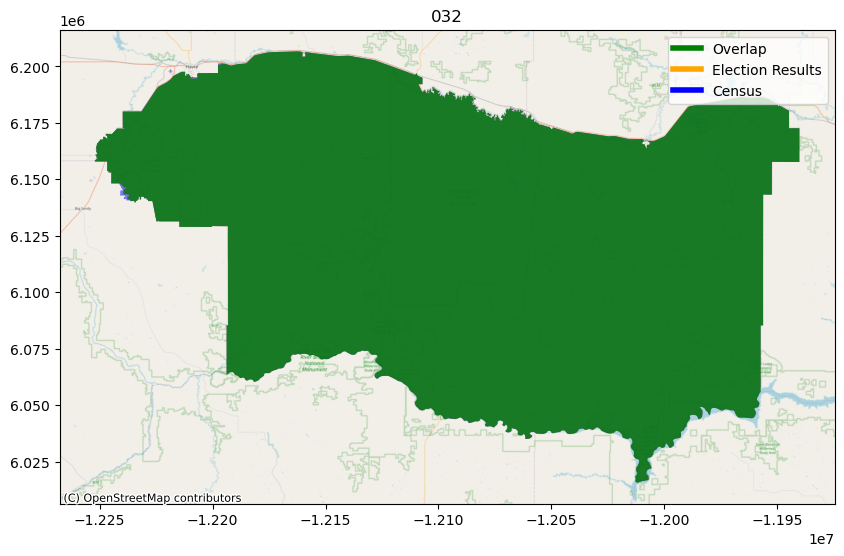

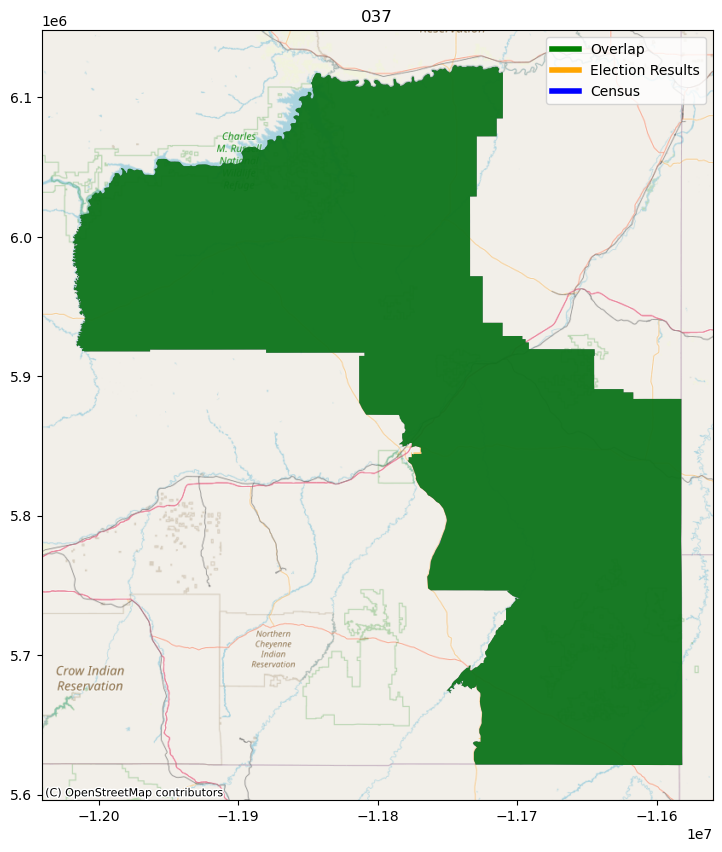

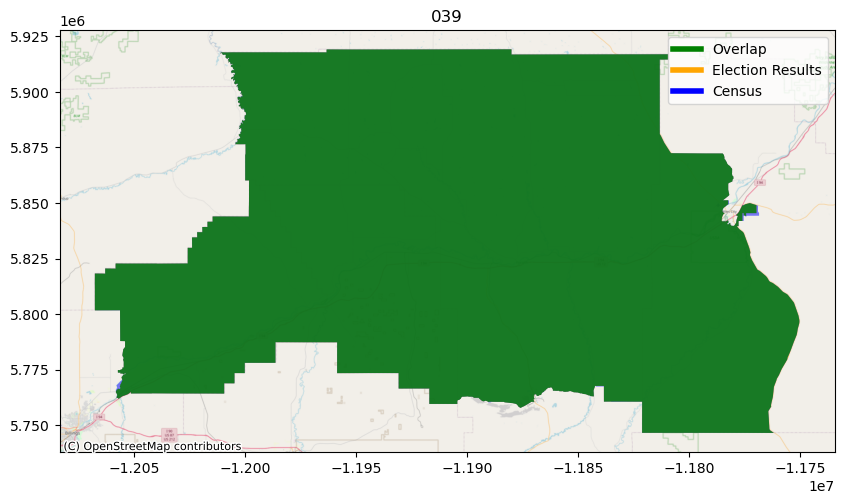

In [155]:
mt_sldl_districts.rename(columns = {"DISTRICT":"SLDL_DIST"}, inplace = True)
mt_sldu_districts.rename(columns = {"DISTRICT":"SLDU_DIST"}, inplace = True)
mt_cong_districts.rename(columns = {"DISTRICT":"CONG_DIST"}, inplace = True)


filtered_sldl_results = mt_22_sldl_prec[~mt_22_sldl_prec["SLDL_DIST"].isna()].dissolve("SLDL_DIST")
filtered_sldl_results.reset_index(inplace = True, drop = False)

filtered_sldu_results = mt_22_st_sldu_prec[~mt_22_st_sldu_prec["SLDU_DIST"].isna()].dissolve("SLDU_DIST")
filtered_sldu_results.reset_index(inplace = True, drop = False)

filtered_cong_results = mt_22_cong_prec[~mt_22_cong_prec["CONG_DIST"].isna()].dissolve("CONG_DIST")
filtered_cong_results.reset_index(inplace = True, drop = False)

mt_sldl_districts["SLDL_DIST"] = mt_sldl_districts["SLDL_DIST"].astype(str).str.zfill(3)
mt_sldu_districts["SLDU_DIST"] = mt_sldu_districts["SLDU_DIST"].astype(str).str.zfill(2)

compare_geometries(filtered_sldu_results, mt_sldu_districts ,"Election Results", "Census", "SLDU_DIST","districts",area_threshold=2)
compare_geometries(filtered_sldl_results, mt_sldl_districts ,"Election Results", "Census", "SLDL_DIST","districts",area_threshold=2)
compare_geometries(filtered_cong_results, mt_cong_districts ,"Election Results", "Census", "CONG_DIST","districts",area_threshold=2)


# Final File Exporting

In [88]:
if not os.path.exists("./mt_gen_2022_prec/mt_gen_2022_prec"):
    if not os.path.exists("./mt_gen_2022_prec"):
        os.mkdir("./mt_gen_2022_prec")
    if not os.path.exists("./mt_gen_2022_prec/mt_22_sldl_prec"):
        os.mkdir("./mt_gen_2022_prec/mt_22_sldl_prec")
    if not os.path.exists("./mt_gen_2022_prec/mt_22_st_sldu_prec"):
        os.mkdir("./mt_gen_2022_prec/mt_22_st_sldu_prec")
    if not os.path.exists("./mt_gen_2022_prec/mt_22_cong_prec"):
        os.mkdir("./mt_gen_2022_prec/mt_22_cong_prec")
    
    



In [89]:
for col in other_columns:
    mt_22_st_sldu_prec[col] = mt_22_st_sldu_prec[col].astype(int)
    
for col in sldl_columns:
    mt_22_sldl_prec[col] = mt_22_sldl_prec[col].astype(int)
    
for col in cong_columns:
    mt_22_cong_prec[col] = mt_22_cong_prec[col].astype(int)

In [90]:
mt_22_st_sldu_prec

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,geometry,HOUSE,SENATE,POLLINGPLA,PrecinctNa,SLDU_DIST,...,GSU42DDUN,GSU42ROLS,GSU43DSCH,GSU43RELL,GSU48DMOR,GSU48RHOR,GSU49DCUR,GSU49RTSC,GSU50DOLS,GSU50RKNO
0,3-:-000001,3.0,Big Horn County,1,"POLYGON ((748306.533 168183.293, 748312.062 16...",42,21,BHC FAIRGROUNDS,PRECINCT #1,21,...,0,0,0,0,0,0,0,0,0,0
1,3-:-000010,3.0,Big Horn County,10,"POLYGON ((794276.781 126179.013, 794286.078 12...",41,21,SPRING CREEK SCHOOL,PRECINCT #10,21,...,0,0,0,0,0,0,0,0,0,0
2,3-:-000014,3.0,Big Horn County,14,"POLYGON ((750469.631 104484.134, 750814.919 10...",41,21,WYOLA SCHOOL - WYOLA,PRECINCT #14,21,...,0,0,0,0,0,0,0,0,0,0
3,3-:-000015,3.0,Big Horn County,15,"POLYGON ((711830.999 135135.514, 711839.192 13...",42,21,PRYOR ELEM SCH - PRYOR,PRECINCT #15,21,...,0,0,0,0,0,0,0,0,0,0
4,3-:-000017,3.0,Big Horn County,17,"POLYGON ((747700.253 166160.735, 747704.731 16...",42,21,BHC FAIRGROUNDS,PRECINCT #17,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,111-:-0056.1,111.0,Yellowstone County,56.1,"POLYGON ((691779.914 182748.910, 691791.060 18...",56,28,YELLOWSTONE VALLEY ELEC. CO-OP,56.1,28,...,0,0,0,0,0,0,0,0,0,0
661,111-:-0056.2,111.0,Yellowstone County,56.2,"POLYGON ((688236.080 180479.076, 688236.136 18...",56,28,LOCKWOOD SCHL,56.2,28,...,0,0,0,0,0,0,0,0,0,0
662,111-:-0056.3,111.0,Yellowstone County,56.3,"POLYGON ((681777.723 168543.262, 681778.113 16...",56,28,BLUE CREEK SCHOOL,56.3,28,...,0,0,0,0,0,0,0,0,0,0
663,29-:-0000NA,029,Flathead County,NA,"POLYGON ((282135.061 464869.497, 283086.741 46...",10,05,NA,NA,08,...,0,0,0,0,0,0,0,0,0,0


In [91]:
mt_22_st_sldu_prec = mt_22_st_sldu_prec[["UNIQUE_ID",'COUNTYFP','COUNTYNM','PRECINCT','PrecinctNa','POLLINGPLA',"SLDU_DIST"] + other_columns + ['geometry']]
mt_22_sldl_prec = mt_22_sldl_prec[["UNIQUE_ID",'COUNTYFP','COUNTYNM','PRECINCT','PrecinctNa','POLLINGPLA',"SLDL_DIST"] + sldl_columns + ['geometry']]
mt_22_cong_prec = mt_22_cong_prec[["UNIQUE_ID",'COUNTYFP','COUNTYNM','PRECINCT','PrecinctNa','POLLINGPLA',"CONG_DIST"] + cong_columns + ['geometry']]

In [94]:
# Rename PrecinctNa column
mt_22_st_sldu_prec.rename(columns = {"PrecinctNa":"PREC_NAME"}, inplace = True)
mt_22_sldl_prec.rename(columns = {"PrecinctNa":"PREC_NAME"}, inplace = True)
mt_22_cong_prec.rename(columns = {"PrecinctNa":"PREC_NAME"}, inplace = True)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55011/3141454784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_22_st_sldu_prec.rename(columns = {"PrecinctNa":"PREC_NAME"}, inplace = True)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55011/3141454784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_22_sldl_prec.rename(columns = {"PrecinctNa":"PREC_NAME"}, inplace = True)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55011/3141454784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [95]:
# Clean COUNTYFP column
mt_22_st_sldu_prec["COUNTYFP"] = mt_22_st_sldu_prec["COUNTYFP"].astype(int).astype(str).str.zfill(3)
mt_22_sldl_prec["COUNTYFP"] = mt_22_sldl_prec["COUNTYFP"].astype(int).astype(str).str.zfill(3)
mt_22_cong_prec["COUNTYFP"] = mt_22_cong_prec["COUNTYFP"].astype(int).astype(str).str.zfill(3)

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [97]:
mt_22_st_sldu_prec.to_file("./mt_gen_2022_prec/mt_22_st_sldu_prec/mt_22_st_sldu_prec.shp")
mt_22_sldl_prec.to_file("./mt_gen_2022_prec/mt_22_sldl_prec/mt_22_sldl_prec.shp")
mt_22_cong_prec.to_file("./mt_gen_2022_prec/mt_22_cong_prec/mt_22_cong_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Random Code For Making README

In [47]:
mt_code = '''G22A48NO     NO   CONSTITUTIONAL AMENDMENT NO. 48                                    
G22A48YES    YES   CONSTITUTIONAL AMENDMENT NO. 48                                   
GPSC1RPIN    RANDY PINOCCI  REPUBLICAN   PUBLIC SERVICE COMMISSIONER DISTRICT 1      
GPSC5DREP    JOHN REPKE  DEMOCRAT   PUBLIC SERVICE COMMISSIONER DISTRICT 5           
GPSC5RBUK    ANN BUKACEK  REPUBLICAN   PUBLIC SERVICE COMMISSIONER DISTRICT 5        
GREF131NO    NO   LEGISLATIVE REFERENDUM NO. 131                                     
GREF131YES   YES   LEGISLATIVE REFERENDUM NO. 131                                    
G22SSC1DAL   BILL DALTON  NON-PARTISAN   SUPREME COURT JUSTICE #1                    
G22SSC1RIC   JIM RICE  NON-PARTISAN   SUPREME COURT JUSTICE #1                       
G22SSC2BRO   JAMES BROWN  NON-PARTISAN   SUPREME COURT JUSTICE #2                    
G22SSC2GUS   INGRID GUSTAFSON  NON-PARTISAN   SUPREME COURT JUSTICE #2               
GCON1DTRA    MONICA TRANEL  DEMOCRAT   UNITED STATES REPRESENTATIVE 1ST DISTRICT     
GCON1LLAM    JOHN LAMB  LIBERTARIAN   UNITED STATES REPRESENTATIVE 1ST DISTRICT      
GCON1RZIN    RYAN K ZINKE  REPUBLICAN   UNITED STATES REPRESENTATIVE 1ST DISTRICT    
GCON2DRON    PENNY RONNING  DEMOCRAT   UNITED STATES REPRESENTATIVE 2ND DISTRICT     
GCON2IBUC    GARY BUCHANAN  INDEPENDENT   UNITED STATES REPRESENTATIVE 2ND DISTRICT  
GCON2LRAN    SAM RANKIN  LIBERTARIAN   UNITED STATES REPRESENTATIVE 2ND DISTRICT     
GCON2RROS    MATT ROSENDALE  REPUBLICAN   UNITED STATES REPRESENTATIVE 2ND DISTRICT  
GSL001RGUN   STEVE GUNDERSON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 1           
GSL002RDUR   NEIL A. DURAM  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 2             
GSL003DGET   ANDREA GETTS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 3                
GSL003RMIT   BRAXTON MITCHELL  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 3          
GSL004DPIN   KIMBERLY PINTER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 4             
GSL004RREG   MATT REGIER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 4               
GSL005DFER   DAVE FERN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 5                   
GSL005RBEN   LYN BENNETT  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 5               
GSL006RREG   AMY REGIER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 6                
GSL007DKEN   ANGELA KENNEDY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 7              
GSL007RSPR   COURTENAY SPRUNGER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 7        
GSL008LDAO   SID DAOUD  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 8                
GSL008RFAL   TERRY FALK  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 8                
GSL009RBRO   TONY BROCKMAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 9             
GSL010RKEE   BOB KEENAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 10               
GSL011RSMI   TANNER J SMITH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 11           
GSL012DLAU   STERLING JAMES LAUDON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 12      
GSL012RREK   LINDA REKSTEN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 12            
GSL013DHIN   COLLEEN HINDS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 13              
GSL013RFIE   PAUL C FIELDER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 13           
GSL014RLOG   DENLEY M LOGE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 14            
GSL015DWEA    MARVIN R. WEATHERWAX JR  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 15    
GSL015RFOS   RALPH FOSTER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 15             
GSL016DWOL   TYSON RUNNING WOLF  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 16         
GSL017DSPO   BARNETT G. SPORKIN-MORRISON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 17
GSL017RFIT   ROSS H FITZGERALD  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 17        
GSL018RJON   LLEW JONES  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 18               
GSL019RMIN   RUSSEL MINER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 19             
GSL020DRIS   SAMANTHA RISPENS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 20           
GSL020RAND   FRED ANDERSON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 20            
GSL021DGRA   LELA GRAHAM  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 21                
GSL021RBUT   ED BUTTREY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 21               
GSL022DHEN   NICK R. D. HENRY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 22           
GSL022LROS   TONY ROSALES  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 22            
GSL022RSHE   LOLA SHELDON-GALLOWAY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 22    
GSL023DSMI   MELISSA SMITH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 23              
GSL023RKER   SCOT KERNS  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 23               
GSL024DBES   BARBARA BESSETTE  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 24           
GSL024RGAL   STEVEN GALLOWAY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 24          
GSL025DKRO   JASMINE KROTKOV  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 25            
GSL025RGIS   STEVE GIST  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 25               
GSL026DROS   KARI ROSENLEAF  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 26             
GSL026RNIK   GEORGE NIKOLAKAKOS  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 26       
GSL027RKAS   JOSH KASSMIER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 27            
GSL028DTUS   PAUL TUSS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 28                  
GSL028RHIL   ED HILL  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 28                  
GSL029RFLA   DOUGLAS FLAMENT  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 29          
GSL030DPAL   WENDY PALMER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 30               
GSL030RBER   JAMES H BERGSTROM  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 30        
GSL031DSMI   FRANK J. SMITH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 31             
GSL031RGOR   ARLIE W GORDON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 31           
GSL032DBOY   JONATHAN WINDY BOY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 32         
GSL033DOPH   JORDAN OPHUS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 33               
GSL033RKNU   CASEY JAMES KNUDSEN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 33      
GSL034RKNU   RHONDA KNUDSEN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 34           
GSL035RLER   BRANDON LER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 35              
GSL036RPHA   BOB PHALEN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 36               
GSL037RSCH   JERRY SCHILLINGER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 37        
GSL038DMUG   STEVE MUGGLI  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 38               
GSL038RKME   GREG KMETZ  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 38               
GSL039RPAR   GARY PARRY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 39               
GSL040ROBL   GREG OBLANDER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 40            
GSL041DPEN   RYNALEA WHITEMAN PENA  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 41      
GSL041RGRE   PAUL GREEN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 41               
GSL042DPER   SHARON STEWART PEREGOY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 42     
GSL042RMCD   VIRGINIA MCDONALD  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 42        
GSL043RSEE   KERRI SEEKINS-CROWE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 43      
GSL044DSMI   MELISSA SMITH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 44              
GSL044RBRE   LARRY BREWSTER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 44           
GSL045RZOL   KATIE ZOLNIKOV  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 45           
GSL046DWAR   TIM WARBURTON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 46              
GSL046RMER   BILL MERCER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 46              
GSL047DBAU   DENISE BAUM  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 47                
GSL047RMAD   THOMAS J MADIGAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 47         
GSL048DMER   JENNIFER MERECKI  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 48           
GSL048RETC   JODEE ETCHART  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 48            
GSL049DKER   EMMA KERR-CARPENTER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 49        
GSL049RWYL   JEFF WYLIE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 49               
GSL050DREA   JAMES REAVIS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 50               
GSL050RSTR   MALLERIE C STROMSWOLD  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 50    
GSL051DBOE   CAROLE BOERNER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 51             
GSL051RYAK   MIKE YAKAWICH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 51            
GSL052DMAR   JENNA MARTIN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 52               
GSL052RESS   SHERRY ESSMANN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 52           
GSL053RNIC   NELLY NICOL  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 53              
GSL054RMOO   TERRY MOORE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 54              
GSL055RDEM   LEE DEMING  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 55               
GSL056RVIN   SUE VINTON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 56               
GSL057DFLA   THOMAS E FLANAGAN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 57          
GSL057RNAV   FIONA B NAVE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 57             
GSL058DGRE   JUDITH P GREGORY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 58           
GSL058RBAR   BRAD BARKER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 58              
GSL059DWEI   RUTH WEISSMAN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 59              
GSL059RMAL   MARTY MALONE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 59             
GSL060DBIS   LAURIE BISHOP  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 60              
GSL060RSKA   DAN SKATTUM  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 60              
GSL061DHAM   JIM HAMILTON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 61               
GSL061GKEL   STEVE KELLY  GREEN   STATE REPRESENTATIVE DISTRICT 61                   
GSL061RBOW   PETER BOWER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 61              
GSL062DSTA   ED STAFMAN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 62                 
GSL062RGRE   MARC GREENDORFER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 62         
GSL063DBUC   ALICE BUCKLEY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 63              
GSL063RPUR   CATHERINE PURCELL  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 63        
GSL064DGRI   ALANAH GRIFFITH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 64            
GSL064LCAM   DOUG CAMPBELL  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 64           
GSL064RGIL   JANE GILLETTE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 64            
GSL065DKOR   KELLY KORTUM  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 65               
GSL065RCOC   JAMES COCCO  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 65              
GSL066DMAT   ERIC MATTHEWS  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 66              
GSL067DMAR   ELIZABETH MARUM  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 67            
GSL067RHIN   JEDEDIAH HINKLE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 67          
GSL068DHAN   JOE HANCOCK  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 68                
GSL068RHIN   CALEB HINKLE  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 68             
GSL069DHAM   ROCKY HAMILTON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 69             
GSL069LMOH    CARL MOHLER JR  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 69          
GSL069RCAR   JENNIFER CARLSON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 69         
GSL070DJAC   JON JACKSON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 70                
GSL070RDOO   JULIE DOOLING  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 70            
GSL071RWAL   KEN WALSH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 71                
GSL072DGIB   HOLT GIBSON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 72                
GSL072RWEL   TOM WELCH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 72                
GSL073DLYN   JENNIFER LYNCH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 73             
GSL073RFRE   JASON FREEMAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 73            
GSL074DHAR   DEREK J HARVEY  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 74             
GSL074RKEP   JAMES W KEPHART  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 74          
GSL075RBER   MARTA BERTOGLIO  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 75          
GSL076DHAW   DONAVON HAWK  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 76               
GSL076RNOR   SUZZANN NORDWICK  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 76         
GSL077DNOV   SARA NOVAK  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 77                 
GSL077RFIT   JOHN FITZPATRICK  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 77         
GSL078RFRA   GREGORY LEE FRAZER  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 78       
GSL079DSMI   LAURA SMITH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 79                
GSL079RPIG   KEITH PIGMAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 79             
GSL080RBEA   BECKY BEARD  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 80              
GSL081DROM   MELISSA ROMANO  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 81             
GSL081RSAR   JILL SARK  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 81                
GSL082DCAF   MARY CAFERRO  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 82               
GSL082RTON   ALDEN TONKAY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 82             
GSL083DABB   KIM ABBOTT  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 83                 
GSL083RLEA   BOB LEACH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 83                
GSL084DCOH   JILL COHENOUR  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 84              
GSL084RRUC   KAITLYN RUCH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 84             
GSL085DSTO   ROSAN STOVER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 85               
GSL085RBIN   MICHELE BINKLEY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 85          
GSL086DBRO   ANNE W BROWN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 86               
GSL086RBED   DAVID BEDEY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 86              
GSL087IMOO   WILL LOVETT MOORE  INDEPENDENT   STATE REPRESENTATIVE DISTRICT 87       
GSL087RMAR   RON MARSHALL  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 87             
GSL088DMOU   KO MOUA  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 88                    
GSL088RRUS   WAYNE RUSK  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 88               
GSL089DSUL   KATIE SULLIVAN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 89             
GSL089RWAN   GARY WANBERG  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 89             
GSL090DMAR   MARILYN MARLER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 90             
GSL090GMAR   GARY MARBUT  GREEN   STATE REPRESENTATIVE DISTRICT 90                   
GSL090LHIN   JOSIAH HINKLE  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 90           
GSL090RAUL   ALAN AULT  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 90                
GSL091DKEO   CONNIE KEOGH  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 91               
GSL091RWAN   BETH WANBERG  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 91             
GSL092DSTE   GARY M. STEIN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 92              
GSL092RHOP   MIKE HOPKINS  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 92             
GSL093DAZZ   SHIRLEY AZZOPARDI  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 93          
GSL093LBRA   DEVIN J BRAATEN  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 93         
GSL093RREA   JOE READ  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 93                 
GSL094DFRA   TOM FRANCE  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 94                 
GSL094RMAP   REBECCA MAPSTON  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 94          
GSL095DHOW   SJ HOWELL  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 95                  
GSL095LWIN   J.C. WINDMUELLER  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 95        
GSL095RSUB   LAUREN SUBITH  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 95            
GSL096DKAR   JONATHAN KARLEN  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 96            
GSL096RWHI   KATHY WHITMAN  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 96            
GSL097DJAC   DEVIN JACKSON  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 97              
GSL097RHEL   LYN HELLEGAARD  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 97           
GSL098DCAR   BOB CARTER  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 98                 
GSL098LARM   RICHARD L ARMERDING  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 98     
GSL098RSHE   SONIA SHEARER-HIETT  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 98      
GSL099DTHA   MARK THANE  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 99                 
GSL099RDAR   RYAN DARLING  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 99             
GSL100DZEP   ZOOEY ZEPHYR  DEMOCRAT   STATE REPRESENTATIVE DISTRICT 100              
GSL100LVAN   MICHAEL VANECEK  LIBERTARIAN   STATE REPRESENTATIVE DISTRICT 100        
GSL100RMCC   SEAN PATRICK MCCOY  REPUBLICAN   STATE REPRESENTATIVE DISTRICT 100      
GSU01RCUF    MICHAEL J CUFFE  REPUBLICAN   STATE SENATOR DISTRICT 1                  
GSU04DWAT    KYLE WATERMAN  DEMOCRAT   STATE SENATOR DISTRICT 4                      
GSU04RFUL    JOHN FULLER  REPUBLICAN   STATE SENATOR DISTRICT 4                      
GSU05RNOL    MARK NOLAND  REPUBLICAN   STATE SENATOR DISTRICT 5                      
GSU08DWEB    SUSAN A WEBBER  DEMOCRAT   STATE SENATOR DISTRICT 8                     
GSU08RJEN    RICK JENNISON  REPUBLICAN   STATE SENATOR DISTRICT 8                    
GSU09RGIL    BRUCE "BUTCH" GILLESPIE  REPUBLICAN   STATE SENATOR DISTRICT 9          
GSU11DJAC    TOM JACOBSON  DEMOCRAT   STATE SENATOR DISTRICT 11                      
GSU11REMR    DANIEL EMRICH  REPUBLICAN   STATE SENATOR DISTRICT 11                   
GSU12DBAC    JACOB BACHMEIER  DEMOCRAT   STATE SENATOR DISTRICT 12                   
GSU12RMCK    WENDY MCKAMEY  REPUBLICAN   STATE SENATOR DISTRICT 12                   
GSU13DSCH    CASEY SCHREINER  DEMOCRAT   STATE SENATOR DISTRICT 13                   
GSU13RTRE    JEREMY TREBAS  REPUBLICAN   STATE SENATOR DISTRICT 13                   
GSU14DBRE    DAVID H BREWER  DEMOCRAT   STATE SENATOR DISTRICT 14                    
GSU14RTEM    RUSSEL E TEMPEL  REPUBLICAN   STATE SENATOR DISTRICT 14                 
GSU15DPAL    CINDY PALMER  DEMOCRAT   STATE SENATOR DISTRICT 15 UNEXPIRED TERM       
GSU15RBAR    DAN BARTEL  REPUBLICAN   STATE SENATOR DISTRICT 15 UNEXPIRED TERM       
GSU19RBOG    KENNETH BOGNER  REPUBLICAN   STATE SENATOR DISTRICT 19                  
GSU20RUSH    BARRY USHER  REPUBLICAN   STATE SENATOR DISTRICT 20                     
GSU22DDEN    TERRY DENNIS  DEMOCRAT   STATE SENATOR DISTRICT 22                      
GSU22RZOL    DANIEL ZOLNIKOV  REPUBLICAN   STATE SENATOR DISTRICT 22                 
GSU24DKEL    KATHY KELKER  DEMOCRAT   STATE SENATOR DISTRICT 24                      
GSU24RTID    ELIJAH TIDSWELL  REPUBLICAN   STATE SENATOR DISTRICT 24                 
GSU27RLEN    DENNIS LENZ  REPUBLICAN   STATE SENATOR DISTRICT 27                     
GSU29RMAN    FORREST JAMES MANDEVILLE  REPUBLICAN   STATE SENATOR DISTRICT 29        
GSU30DISA    JAMIE L ISALY  DEMOCRAT   STATE SENATOR DISTRICT 30                     
GSU30RESP    JOHN ESP  REPUBLICAN   STATE SENATOR DISTRICT 30                        
GSU32DFLO    PAT FLOWERS  DEMOCRAT   STATE SENATOR DISTRICT 32                       
GSU32RCHA    RANDY CHAMBERLIN  REPUBLICAN   STATE SENATOR DISTRICT 32                
GSU33DHAY    DENISE HAYMAN  DEMOCRAT   STATE SENATOR DISTRICT 33                     
GSU33RDEW    ADAM DEWIS  REPUBLICAN   STATE SENATOR DISTRICT 33                      
GSU34DLYN    DAMION LYNN  DEMOCRAT   STATE SENATOR DISTRICT 34                       
GSU34RVAN    SHELLEY VANCE  REPUBLICAN   STATE SENATOR DISTRICT 34                   
GSU39DMUL    JESSE JAMES MULLEN  DEMOCRAT   STATE SENATOR DISTRICT 39 UNEXPIRED TERM 
GSU39RVER    TERRY VERMEIRE  REPUBLICAN   STATE SENATOR DISTRICT 39 UNEXPIRED TERM   
GSU41DELL    JANET ELLIS  DEMOCRAT   STATE SENATOR DISTRICT 41                       
GSU41RGAL    DAVE GALT  REPUBLICAN   STATE SENATOR DISTRICT 41                       
GSU42DDUN    MARY ANN DUNWELL  DEMOCRAT   STATE SENATOR DISTRICT 42                  
GSU42ROLS    MATT OLSON  REPUBLICAN   STATE SENATOR DISTRICT 42                      
GSU43DSCH    JOHN F SCHNEEBERGER  DEMOCRAT   STATE SENATOR DISTRICT 43               
GSU43RELL    JASON W ELLSWORTH  REPUBLICAN   STATE SENATOR DISTRICT 43               
GSU48DMOR    SHANE A. MORIGEAU  DEMOCRAT   STATE SENATOR DISTRICT 48                 
GSU48RHOR    JACOB VAN HORN  REPUBLICAN   STATE SENATOR DISTRICT 48                  
GSU49DCUR    WILLIS CURDY  DEMOCRAT   STATE SENATOR DISTRICT 49                      
GSU49RTSC    BRAD TSCHIDA  REPUBLICAN   STATE SENATOR DISTRICT 49                    
GSU50DOLS    ANDREA OLSEN  DEMOCRAT   STATE SENATOR DISTRICT 50                      
GSU50RKNO    NICK KNOWLES  REPUBLICAN   STATE SENATOR DISTRICT 50'''

In [48]:
rename_dict = {}
for val in mt_code.split("\n"):
    ind = val.find(" ")
    first = val[:ind].strip()
    second = val[ind+1:].strip().title()
    second = second.replace("   ", " - ")
    second = second.replace("  ", " - ")
    rename_dict[first] = second

In [49]:
pd.DataFrame(rename_dict.items()).to_csv("./field_names.csv", index = False)